# Income Analysis

A Data-Driven Approach to Predict whether income exceeds $50K/yr based on census data

In [22]:
# library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [24]:
import pandas as pd

adult = pd.read_csv('adult.data', sep=', ', header=None,engine='python')
header=['age','workClass',"fnlwgt","education","educationNum","maritalStatus","occupation","relationship","race","gender","capitalGain","capitalLoss","hoursPerWeekWork","nativeCountry","income"]
adult.columns = header

In [25]:
adult.head()

,age,workClass,fnlwgt,education,educationNum,maritalStatus,occupation,relationship,race,gender,capitalGain,capitalLoss,hoursPerWeekWork,nativeCountry,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [26]:
# change the "?" values in the "occupation" column to "unknown"
adult['occupation'] = adult['occupation'].replace('?', 'unknown')
# change the "?" values in the "workClass" column to "unknown"
adult['workClass'] = adult['workClass'].replace('?', 'unknown')

In [27]:
adult.dtypes

age                  int64
workClass           object
fnlwgt               int64
education           object
educationNum         int64
maritalStatus       object
occupation          object
relationship        object
race                object
gender              object
capitalGain          int64
capitalLoss          int64
hoursPerWeekWork     int64
nativeCountry       object
income              object
dtype: object

In [28]:
# Check for missing or blank values
print(adult.isna().sum())

age                 0
workClass           0
fnlwgt              0
education           0
educationNum        0
maritalStatus       0
occupation          0
relationship        0
race                0
gender              0
capitalGain         0
capitalLoss         0
hoursPerWeekWork    0
nativeCountry       0
income              0
dtype: int64


In [29]:
# Check for missing values
print(adult.isnull().sum())

age                 0
workClass           0
fnlwgt              0
education           0
educationNum        0
maritalStatus       0
occupation          0
relationship        0
race                0
gender              0
capitalGain         0
capitalLoss         0
hoursPerWeekWork    0
nativeCountry       0
income              0
dtype: int64


Text(0.5, 1.0, 'Correlation Matrix')

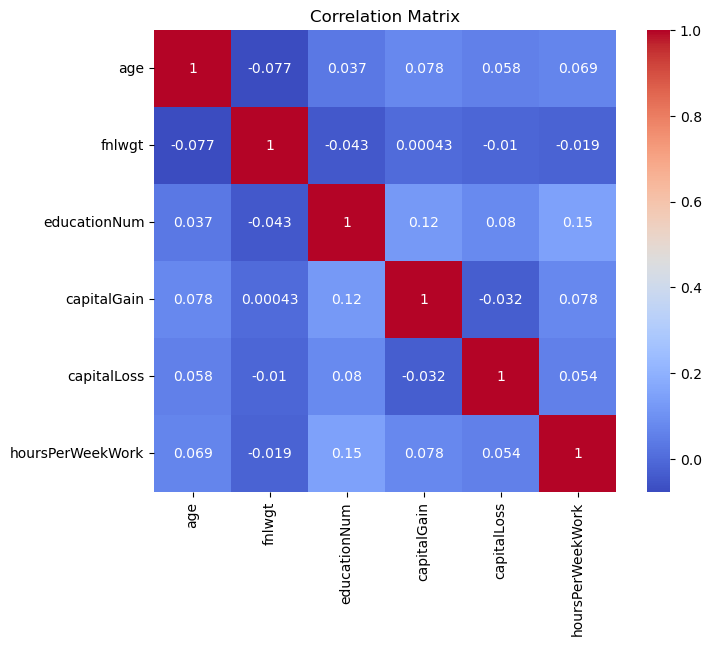

In [30]:
# correlation between numeric variables
numeric_columns = adult.select_dtypes(include='number')
correlation_matrix = numeric_columns.corr()
# correlation graph
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')

In [31]:
# a correlation value below 0.5 suggests a weak linear relationship between the variables,

In [32]:
adult['gender'].value_counts()

Male      21790
Female    10771
Name: gender, dtype: int64

### Data Prepocessing

In [33]:
# one-hot encoding

workClass_encoded=pd.get_dummies(adult['workClass'],prefix="workClass")
education_encoded=pd.get_dummies(adult['education'],prefix="education")
maritalStatus_encoded=pd.get_dummies(adult['maritalStatus'],prefix="maritalStatus")
occupation_encoded=pd.get_dummies(adult['occupation'],prefix="occupation")
relationship_encoded=pd.get_dummies(adult["relationship"],prefix="relationship")
race_encoded=pd.get_dummies(adult["race"],prefix="race")
nativeCountry_encoded=pd.get_dummies(adult["nativeCountry"],prefix="nativeCountry")

In [34]:
# join the encoded data with original data frame
adult=pd.concat([adult,
                  workClass_encoded,
                 education_encoded,
                 maritalStatus_encoded,
                 occupation_encoded,
                 relationship_encoded,
                 race_encoded,
                 nativeCountry_encoded],axis=1)

In [35]:
# convert the categorical variable into binary
adult['gender']=(adult["gender"]=="Male").astype(int)

In [36]:
# Drop the uncoded column

adultClean=adult.drop(["workClass",
                       "education",
                       "maritalStatus",
                       "occupation",
                      "relationship",
                      "race",
                      "nativeCountry",
                      "gender"],axis=1)

### Value counts for response variable

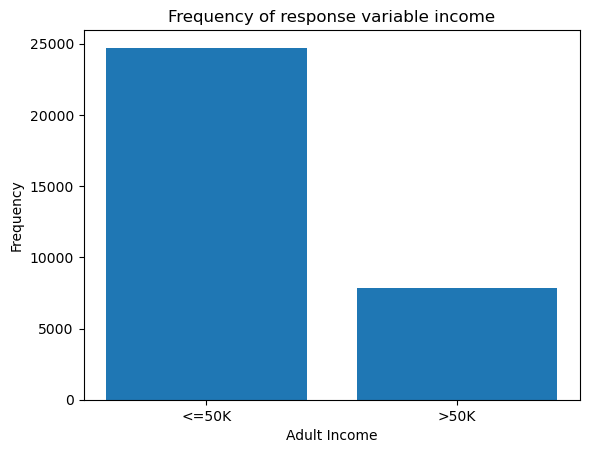

In [37]:
countsIncome=adultClean['income'].value_counts()
plt.bar(countsIncome.index,countsIncome.values)
plt.title("Frequency of response variable income")
plt.xlabel("Adult Income")
plt.ylabel("Frequency")
plt.show()

### Compute the percentage of <=50k and >50k

In [38]:
percentageLess50K=(countsIncome['<=50K']/len(adultClean))*100
percentageGreater50K=(countsIncome['>50K']/len(adultClean))*100

print("Percentage of adult who earn less than or equal to 50K :{:.2f}%".format(percentageLess50K))
print("Percentage of adult who earn greater than 50K :{:.2f}%".format(percentageGreater50K))

Percentage of adult who earn less than or equal to 50K :75.92%
Percentage of adult who earn greater than 50K :24.08%


### Perform oversampling using SMOTE

In [39]:
X=adultClean.drop('income',axis=1)
y=adultClean['income']

In [40]:
oversampler = SMOTE(sampling_strategy='auto', random_state=123)
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)
adultClean = pd.concat([X_oversampled, y_oversampled], axis=1)
print(adultClean['income'].value_counts())

<=50K    24720
>50K     24720
Name: income, dtype: int64


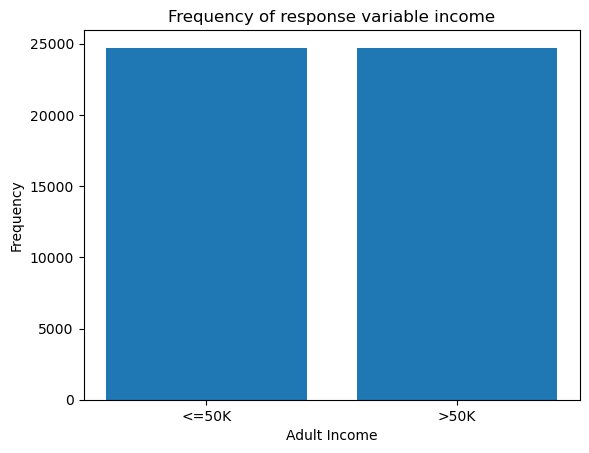

In [41]:
countsIncome=adultClean['income'].value_counts()
plt.bar(countsIncome.index,countsIncome.values)
plt.title("Frequency of response variable income")
plt.xlabel("Adult Income")
plt.ylabel("Frequency")
plt.show()

In [42]:
percentageLess50K=(countsIncome['<=50K']/len(adultClean))*100
percentageGreater50K=(countsIncome['>50K']/len(adultClean))*100

print("Percentage of adult who earn less than or equal to 50K :{:.2f}%".format(percentageLess50K))
print("Percentage of adult who earn greater than 50K :{:.2f}%".format(percentageGreater50K))

Percentage of adult who earn less than or equal to 50K :50.00%
Percentage of adult who earn greater than 50K :50.00%


### Convert the response variable into binary 0 and 1

In [43]:
adultClean['income']=adultClean['income'].apply(lambda x: 1 if x == ">50K" else 0)
adultClean['income'].value_counts()

0    24720
1    24720
Name: income, dtype: int64

### Creating training and testing data

In [44]:
X_train, X_test, y_train, y_test = train_test_split(adultClean.drop('income', axis=1), adultClean['income'], test_size=0.2, random_state=123)
adult_train = pd.concat([X_train, y_train], axis=1)
adult_test = pd.concat([X_test, y_test], axis=1)

### Fit a logistic regression model

In [45]:
# Create a logistic Regression model
logreg=LogisticRegression()
# Fit the model using cross validation
cv_scores=cross_val_score(logreg,X_train,y_train,cv=10)
# Train the model on the full training data
logreg.fit(X_train,y_train)
predictions=logreg.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.61      0.72      0.66      4979
           1       0.65      0.53      0.58      4909

    accuracy                           0.62      9888
   macro avg       0.63      0.62      0.62      9888
weighted avg       0.63      0.62      0.62      9888



### Calculate the confusion matrix

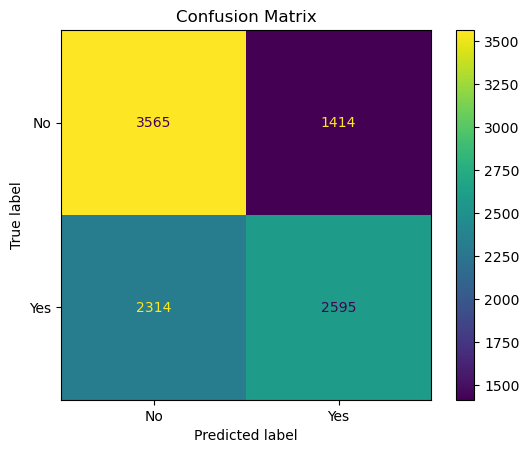

In [55]:
cm=confusion_matrix(y_test,predictions)
cm_display=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["No","Yes"])
cm_display.plot()
plt.title("Confusion Matrix")
plt.show()


In [53]:
#Sensitivity
sensitivity=0.53
specificity=0.72
falsePositive=1414
falseNegative=2314
totalSamples=(4979+4909)
#misClassificationRate
misClassificationRate=(falsePositive+falseNegative)/totalSamples
misClassificationRate

0.37702265372168287

### ROC curve

AUC: 0.62


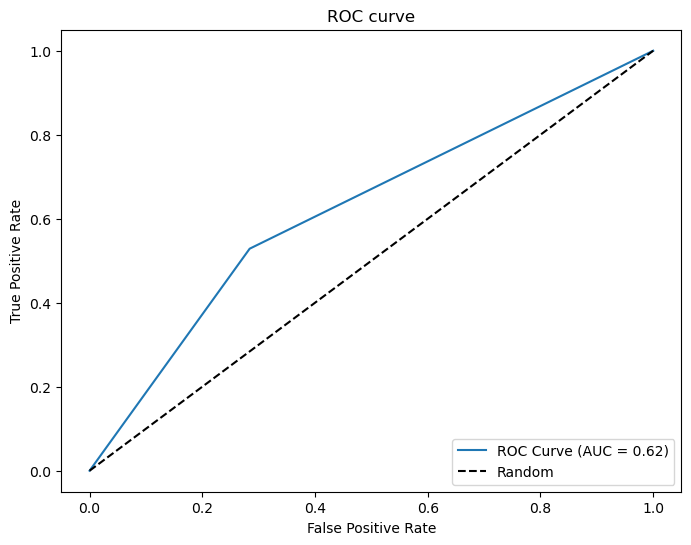

In [47]:
fpr,tpr,thresholds = roc_curve(y_test,predictions)
auc_value=auc(fpr,tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,label="ROC Curve (AUC = {:.2f})".format(auc_value))
plt.plot([0,1],[0,1],'k--',label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show
print("AUC: {:.2f}".format(auc_value))

### Fit the Random Forest Classifier to the training data

In [54]:
rf=RandomForestClassifier()
cv_scores=cross_val_score(rf,X_train,y_train,cv=10)
rf.fit(X_train,y_train)
predictions2=rf.predict(X_test)
print(classification_report(y_test,predictions2))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      4979
           1       0.91      0.89      0.90      4909

    accuracy                           0.90      9888
   macro avg       0.90      0.90      0.90      9888
weighted avg       0.90      0.90      0.90      9888



### Calculate the confusion matrix

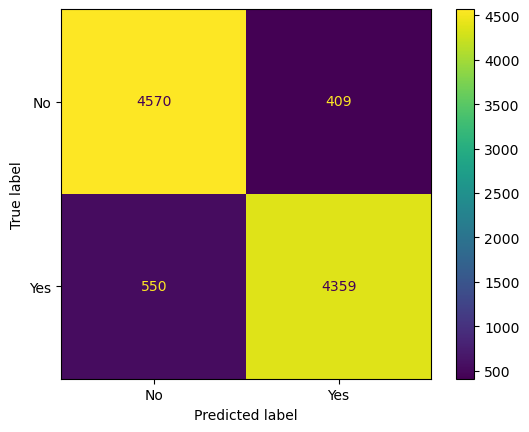

In [56]:
cm2=confusion_matrix(y_test,predictions2)
cm_display2=ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=["No","Yes"])
cm_display2.plot()
plt.show()

In [57]:
#Sensitivity
sensitivity=0.89
specificity=0.91
falsePositive=409
falseNegative=550
totalSamples=(4979+4909)
#misClassificationRate
misClassificationRate=(falsePositive+falseNegative)/totalSamples
misClassificationRate

0.09698624595469256

### ROC curve

AUC: 0.62


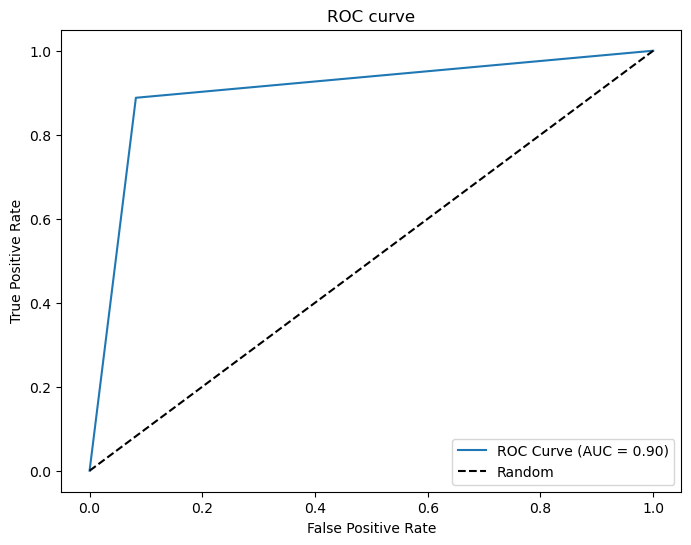

In [58]:
fpr,tpr,thresholds = roc_curve(y_test,predictions2)
auc_value2=auc(fpr,tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,label="ROC Curve (AUC = {:.2f})".format(auc_value2))
plt.plot([0,1],[0,1],'k--',label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show
print("AUC: {:.2f}".format(auc_value))

### Fit the K-nearest neighbor to the training data

In [59]:
knn=KNeighborsClassifier()
cv_scores=cross_val_score(knn,X_train,y_train,cv=10)
knn.fit(X_train,y_train)
predictions3=knn.predict(X_test)
print(classification_report(y_test,predictions3))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70      4979
           1       0.69      0.75      0.72      4909

    accuracy                           0.71      9888
   macro avg       0.71      0.71      0.71      9888
weighted avg       0.71      0.71      0.71      9888



### Calculate the confusion Matrix

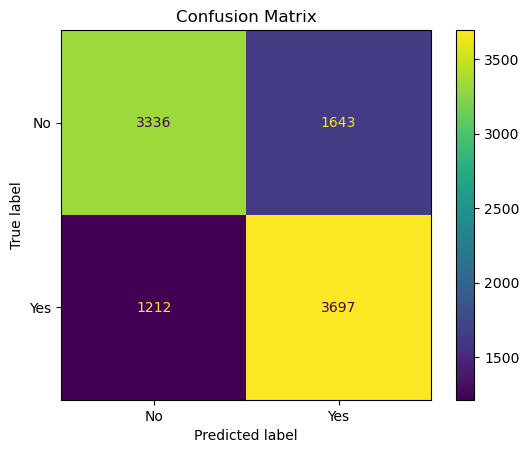

In [62]:
cm3=confusion_matrix(y_test,predictions3)
cm_display3=ConfusionMatrixDisplay(confusion_matrix=cm3,display_labels=["No","Yes"])
cm_display3.plot()
plt.title("Confusion Matrix")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

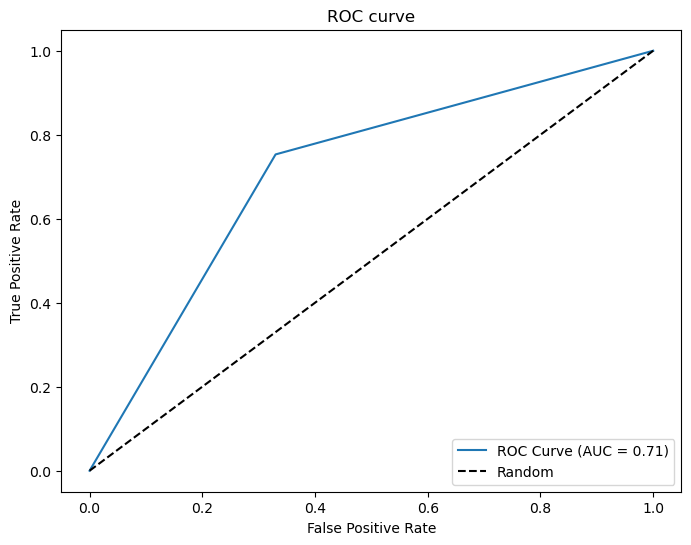

In [61]:
fpr,tpr,thresholds = roc_curve(y_test,predictions3)
auc_value3=auc(fpr,tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,label="ROC Curve (AUC = {:.2f})".format(auc_value3))
plt.plot([0,1],[0,1],'k--',label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show

In [60]:
#Sensitivity
sensitivity=0.75
specificity=0.67
falsePositive=1643
falseNegative=1212
totalSamples=(4979+4909)
#misClassificationRate
misClassificationRate=(falsePositive+falseNegative)/totalSamples
misClassificationRate

0.2887338187702265